# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

When finished, you can close the environment.

In [5]:
import numpy as np
import random
import copy
from collections import namedtuple, deque

import datetime
import torch

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from collections import deque
from maddpg import Agent

NUM_AGENTS = 2

def maddpg(n_episodes, max_t, config, window_size=100, print_every=10, early_break=False):
    agents = [Agent(config, state_size=state_size, action_size=action_size, random_seed=0) for _ in range(2)]
    scores_deque = deque(maxlen=window_size)
    scores_short = deque(maxlen=print_every)
    all_scores = []
    start_time = datetime.datetime.now().strftime("%H:%M:%S")
    print('{} Starts training'.format(start_time))
    
    best = [-np.inf, -np.inf]
    
    for i_episode in range(1, n_episodes+1):
        
        for i in range(NUM_AGENTS):
            agents[i].reset()
            
        env_info = env.reset(train_mode=True)[brain_name]        
        states = np.reshape(env_info.vector_observations, (1,48))        
        scores = np.zeros(NUM_AGENTS)
        sum_ep = np.zeros(2)
                    
        t = 0
        
        while True:
            t += 1            
            
            actions = np.concatenate((agents[0].act(states), agents[1].act(states)), axis=0).flatten()
            env_info = env.step(actions)[brain_name]
            
            next_states = np.reshape(env_info.vector_observations, (1, 48))
            rewards = env_info.rewards
            dones = env_info.local_done
                        
            # Perform agent step
            for i in range(NUM_AGENTS):  
                agents[i].step(t, states, actions, rewards[i], next_states, dones, i)
                sum_ep[i] += rewards[i]
                
            states = next_states
            scores += np.max(rewards)
            
            if early_break and np.any(dones):
                break

        for i in range(NUM_AGENTS):
            if best[i] < sum_ep[i]:
                best[i] = sum_ep[i]
                            
        max_score = np.max(scores)
        scores_deque.append(max_score)
        scores_short.append(max_score)
        all_scores.append(max_score)            
            
        if i_episode % print_every == 0:        
            current_time = datetime.datetime.now().strftime("%H:%M:%S")
            debug_string = '{} Episode {}\t Episode score: {:.3f}\tAvg  100: {:.3f} {:.3f}, bests: {:.3f} {:.3f}'.format(current_time, i_episode, max_score, np.mean(scores_deque), np.mean(scores_short), best[0], best[1])
            print(debug_string)
           
        if np.mean(scores_deque)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode-100, np.mean(scores_deque)))
            
            for agent_i in range(2):
                torch.save(agents[i].actor_local.state_dict(), 'agent_{}_checkpoint_actor.pth'.format(agent_i))
                torch.save(agents[i].critic_local.state_dict(), 'agent_{}_checkpoint_critic.pth'.format(agent_i))
            break
            
    return all_scores

In [7]:
config = {
    'BUFFER_SIZE': int(1e6),        # replay buffer size
    'BATCH_SIZE': 128,              # minibatch size
    'GAMMA': 0.99,                  # discount factor
    'TAU': 7e-2,                    # for soft update of target parameters
    'LR_ACTOR': 1e-3,               # learning rate of the actor 
    'LR_CRITIC': 1e-3,              # learning rate of the critic
    'WEIGHT_DECAY': 0,              # L2 weight decay

    'DDPG_LEARN_TIMES': 1,
    'DDPG_UPDATE_EVERY': 1,

    'NOISE_ASYNC': False,
    'NOISE_EPSILON_MIN': 4e-4,
    'NOISE_EPSILON': 5.5,           # explore/exploit from the noise generator
    'NOISE_EPSILON_DECAY': 6e-4,    # decay rate for noise process

    'OU_THETA': 0.12,
    'OU_SIGMA': 0.2,

    'device': torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
}


print(f"Using device: {config['device']}")
scores = maddpg(3000, 2000, config, early_break = True, print_every = 10)

Using device: cuda:0
03:37:01 Starts training
03:37:03 Episode 10	 Episode score: 0.000	Avg  100: 0.010 0.010, bests: 0.000 0.090
03:37:11 Episode 20	 Episode score: 0.000	Avg  100: 0.010 0.010, bests: 0.000 0.090
03:37:19 Episode 30	 Episode score: 0.000	Avg  100: 0.010 0.010, bests: 0.000 0.100
03:37:31 Episode 40	 Episode score: 0.200	Avg  100: 0.023 0.060, bests: 0.100 0.100
03:37:42 Episode 50	 Episode score: 0.000	Avg  100: 0.026 0.040, bests: 0.100 0.100
03:37:52 Episode 60	 Episode score: 0.100	Avg  100: 0.027 0.030, bests: 0.100 0.100
03:38:01 Episode 70	 Episode score: 0.000	Avg  100: 0.027 0.030, bests: 0.100 0.100
03:38:10 Episode 80	 Episode score: 0.000	Avg  100: 0.026 0.020, bests: 0.100 0.100
03:38:22 Episode 90	 Episode score: 0.100	Avg  100: 0.030 0.060, bests: 0.100 0.100
03:38:33 Episode 100	 Episode score: 0.100	Avg  100: 0.032 0.050, bests: 0.100 0.100
03:38:48 Episode 110	 Episode score: 0.000	Avg  100: 0.040 0.090, bests: 0.100 0.100
03:38:59 Episode 120	 Episod

In [8]:
env.close()

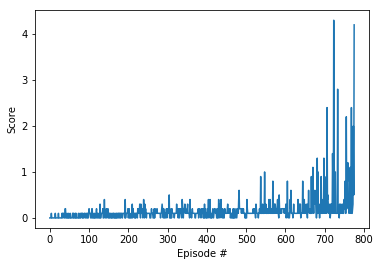

<Figure size 432x288 with 0 Axes>

In [9]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
plt.savefig('result.png')